# Simulations

In [1]:
### Import Packages ###
import os
import numpy as np
import pandas as pd
import math as math
import random as random
from scipy import stats
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

### Local Packages ###
from utils.Auxiliary import *


---

In [2]:
# Load Data #

# Input #
DataFile = "BreastCancer"
rashomon_bound_adder = 0.05
regularization = 0.01
TestProportion = 0.3
CandidateProportion = 0.8
Seed = 0

df = LoadData(DataFile)
random.seed(Seed)
np.random.seed(Seed)

# Train Test Candidate Split #
from utils.Main import TrainTestCandidateSplit
df_Train, df_Test, df_Candidate = TrainTestCandidateSplit(df, TestProportion, CandidateProportion)

### TRAIN TREEFARMS ###
# TreeFarms #
config = {"regularization": regularization, "rashomon_bound_adder": rashomon_bound_adder}
TreeFarmsModel = TREEFARMS(config)
TreeFarmsModel.fit(df_Train.loc[:, df_Train.columns != "Y"], df_Train["Y"])
TreeCount = TreeFarmsModel.get_tree_count()

null
Finding Optimal Objective...
treefarms reported successful execution{
  "false": {
    "false": {
      "false": {
        "complexity": 0.009999999776482582,
        "loss": 0.020618556067347527,
        "name": "Y",
        "prediction": 1
      },
      "feature": 6,
      "name": "BareNuclei_1",
      "reference": 1,
      "relation": "==",
      "true": {
        "false": {
          "complexity": 0.009999999776482582,
          "loss": 0.0,
          "name": "Y",
          "prediction": 1
        },
        "feature": 5,
        "name": "SingleEpithelialCellSize_2",
        "reference": 1,
        "relation": "==",
        "true": {
          "complexity": 0.009999999776482582,
          "loss": 0.0,
          "name": "Y",
          "prediction": 0
        },
        "type": "integral"
      },
      "type": "integral"
    },
    "feature": 1,
    "name": "CellSize_1",
    "reference": 1,
    "relation": "==",
    "true": {
      "complexity": 0.009999999776482582,
      "lo

In [3]:
print(TreeCount)

1141871


In [4]:
# Duplicate and Unique #
PredictionArray_Duplicate = pd.DataFrame(np.array([TreeFarmsModel[i].predict(df_Train.loc[:, df_Train.columns != "Y"]) for i in range(TreeCount)]))
PredictionArray_Unique = pd.DataFrame(PredictionArray_Duplicate).drop_duplicates(keep='first', ignore_index=False)
TrueValues = df_Train["Y"].to_numpy()
PredictionArray = PredictionArray_Unique

In [5]:
### TRAINING ACCURACY ###
# Training Accuracy #
TreeClassificationAccuracy = PredictionArray.eq(TrueValues, axis=1).mean(axis=1)
BestAccuracy = float(np.max(TreeClassificationAccuracy))

# Threshold Values #
EpsilonVec = BestAccuracy - TreeClassificationAccuracy
MinEpsilon = float(np.min(EpsilonVec))
MaxEpsilon = float(np.max(EpsilonVec))
ThresholdValues = np.linspace(MinEpsilon, MaxEpsilon, 100)

In [11]:
### TEST ACCURACY ###
# Set Up #
ModelIndicesVec = []
Epsilon_F1Score = []
Epsilon_ClassAccuracy = []
for Threshold in ThresholdValues:

    # Filter Models Based on Threshold
    ModelIndices = EpsilonVec[EpsilonVec <= Threshold].index.tolist()
    Test_Predictions = pd.DataFrame(np.array([TreeFarmsModel[i].predict(df_Test.loc[:, df_Test.columns != "Y"]) for i in ModelIndices]))
    Test_Predictions.columns = df_Test.index.astype(str)

    # Compute Ensemble Prediction (Mode)
    EnsemblePrediction = pd.Series(stats.mode(Test_Predictions, axis=0, keepdims=True)[0].flatten())
    EnsemblePrediction.index = df_Test["Y"].index

    # Compute Metrics
    F1Score = float(f1_score(df_Test["Y"], EnsemblePrediction, average='micro'))
    ClassAccuracy = float(np.mean(EnsemblePrediction == df_Test["Y"]))

    # Print
    print("Models: " + str(len(ModelIndices)) + "| Accuracy: " + str(ClassAccuracy))


    # Append Metrics
    ModelIndicesVec.append(ModelIndices)
    Epsilon_F1Score.append(F1Score)
    Epsilon_ClassAccuracy.append(ClassAccuracy)

Models: 2| Accuracy: 0.9333333333333333
Models: 2| Accuracy: 0.9333333333333333
Models: 2| Accuracy: 0.9333333333333333
Models: 2| Accuracy: 0.9333333333333333
Models: 2| Accuracy: 0.9333333333333333
Models: 2| Accuracy: 0.9333333333333333
Models: 2| Accuracy: 0.9333333333333333
Models: 2| Accuracy: 0.9333333333333333
Models: 2| Accuracy: 0.9333333333333333
Models: 2| Accuracy: 0.9333333333333333
Models: 2| Accuracy: 0.9333333333333333
Models: 2| Accuracy: 0.9333333333333333
Models: 2| Accuracy: 0.9333333333333333
Models: 2| Accuracy: 0.9333333333333333
Models: 2| Accuracy: 0.9333333333333333
Models: 2| Accuracy: 0.9333333333333333
Models: 2| Accuracy: 0.9333333333333333
Models: 31| Accuracy: 0.9238095238095239
Models: 31| Accuracy: 0.9238095238095239
Models: 31| Accuracy: 0.9238095238095239
Models: 31| Accuracy: 0.9238095238095239
Models: 31| Accuracy: 0.9238095238095239
Models: 31| Accuracy: 0.9238095238095239
Models: 31| Accuracy: 0.9238095238095239
Models: 31| Accuracy: 0.923809523

In [12]:
### OUTPUT ###
SimulationResults = {
    "ModelIndicesVec" : ModelIndicesVec,
    "ThresholdValues" : ThresholdValues,
    "Epsilon_F1Score" : Epsilon_F1Score,
    "Epsilon_ClassAccuracy" : Epsilon_ClassAccuracy}

In [13]:
# with open("/Users/simondn/Documents/RashomonActiveLearning/Results/TEST.pkl", "rb") as file:
#     data = pickle.load(file)

# ModelIndicesVec = data["ModelIndicesVec"]
# ThresholdValues = data["ThresholdValues"]
# Epsilon_F1Score = data["Epsilon_F1Score"]
# Epsilon_ClassAccuracy = data["Epsilon_ClassAccuracy"]

# Plot

## Model Length

# Accuracy by Rashomon Threshold

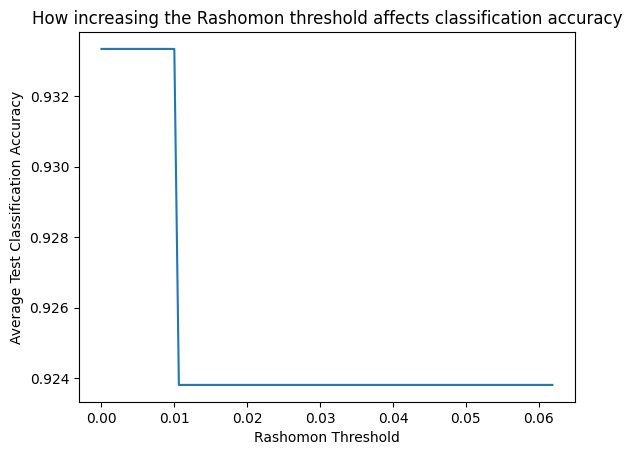

In [14]:
### Plot Accuracy ###
plt.plot(ThresholdValues, Epsilon_ClassAccuracy, label="Average Classification Accuracy")
plt.xlabel("Rashomon Threshold")
plt.ylabel("Average Test Classification Accuracy")
plt.title("How increasing the Rashomon threshold affects classification accuracy")
plt.show()

# F1 by Rashomon Threshold

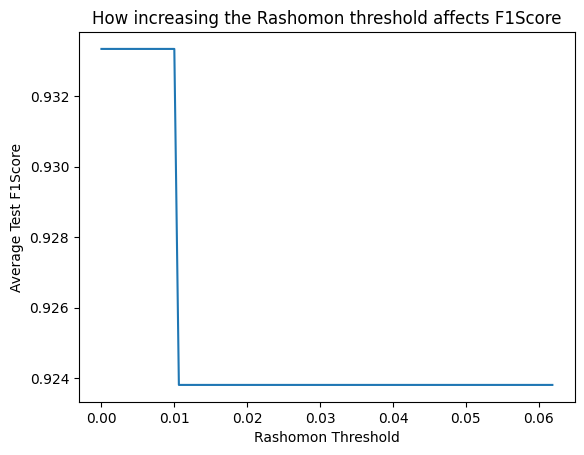

In [10]:
plt.plot(ThresholdValues, Epsilon_F1Score, label="Average F1 Score Accuracy")
plt.xlabel("Rashomon Threshold")
plt.ylabel("Average Test F1Score")
plt.title("How increasing the Rashomon threshold affects F1Score")
plt.show()